## MINIPROYECTO 3
CLASIFICACION DE IMAGENES DE POKEMON

JHON JAIRO CASTILLO CIFUENTES

2167742

-----

**INTRODUCCION**

Las redes neuronales son una herramienta que nos ayudan en diversas tareas como el reconocimiento de sonido, video o imagenes, por esta razon se han vuelto un elemento muy recurrido cuando se habla de inteligencia artificial.

En este proyecto se realiza la clasificación de imagenes de 15 distintos tipos de pokemón(Charizard, bulbasaur, squirtle, pikachu, ónix,buterfree,pidgeot,lickitung,Dragonair,mew, mr mine, lapras, articuno, gyarados, evee), para ello se realizo una seleccion de archivos de un dataset con 150 tipos de pokemon.

Para la clasificación se usan 3 tipos de redes neuronales (MLP,CNN y transfer learning), estas se evaluaran y se compararan para ver sus pros y contras.

-----


**DESARROLLO**


El primer paso en el desarrollo de este proyecto es el llamado de las librerias necesarias para que el código funcione de manera adecuada, entre ellas tenemos librerias de manejo de vectores, de manejo de imagenes de procesamiento entre otras.

In [2]:
# Common Tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile #Manejar archivos comprimidos en Colab
import os, pathlib, PIL

#Keras layers and image preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
#from keras.utils import to_categorical
#from keras.utils import plot_model

# Classification report and visualization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

# Save and load best CNN models
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#Transfer Learning and MLP Layers
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input

#Data visualization (Bokeh)
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter
from bokeh.layouts import row
import random
import cv2

Una vez se tienen las librerias se realiza el procesamiento del dataset, para esto se descomprime un dataset previamente subido a colab el cual cuenta con dos carpetas principales (train y test) con las que se entrenaran nuestros modelos de redes neuronales.

Cada carpeta tiene en su interior 15 carpetas con los nombres de pokemon que se van a clasificar como podemos ver a continuación.

In [3]:
zip_ref = zipfile.ZipFile('/content/Data.zip', 'r')
zip_ref.extractall('files') #Extracción de archivos descargados
zip_ref.close()

In [4]:
train_dir='/content/files/Data/train'
test_dir='/content/files/Data/test'

In [5]:
data_dir = pathlib.Path(train_dir)
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)
print('Folder Structure:')
for f in folder:
    print(f)
print('\nNumber of images: ', len(images))

Folder Structure:
/content/files/Data/train/Squirtle
/content/files/Data/train/Bulbasaur
/content/files/Data/train/Lickitung
/content/files/Data/train/MrMime
/content/files/Data/train/Charizard
/content/files/Data/train/Gengar
/content/files/Data/train/Articuno
/content/files/Data/train/Pidgeot
/content/files/Data/train/Eevee
/content/files/Data/train/Lapras
/content/files/Data/train/Onix
/content/files/Data/train/Mew
/content/files/Data/train/Dragonite
/content/files/Data/train/Butterfree
/content/files/Data/train/Pikachu

Number of images:  554


Ahora que se tiene la ruta de los datos de entrenamiento y validacion se procede a verificar las imagenes, por lo que se elige una lista de imagenes al azar para su visualizacion y verificar que el programa las usa correctamente.

In [6]:
data_dir = pathlib.Path(test_dir)
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)
print('Folder Structure:')
for f in folder:
    print(f)
print('\nNumber of images: ', len(images))

Folder Structure:
/content/files/Data/test/Squirtle
/content/files/Data/test/Bulbasaur
/content/files/Data/test/Lickitung
/content/files/Data/test/MrMime
/content/files/Data/test/Charizard
/content/files/Data/test/Gengar
/content/files/Data/test/Articuno
/content/files/Data/test/Pidgeot
/content/files/Data/test/Eevee
/content/files/Data/test/Lapras
/content/files/Data/test/Onix
/content/files/Data/test/Mew
/content/files/Data/test/Dragonite
/content/files/Data/test/Butterfree
/content/files/Data/test/Pikachu

Number of images:  60


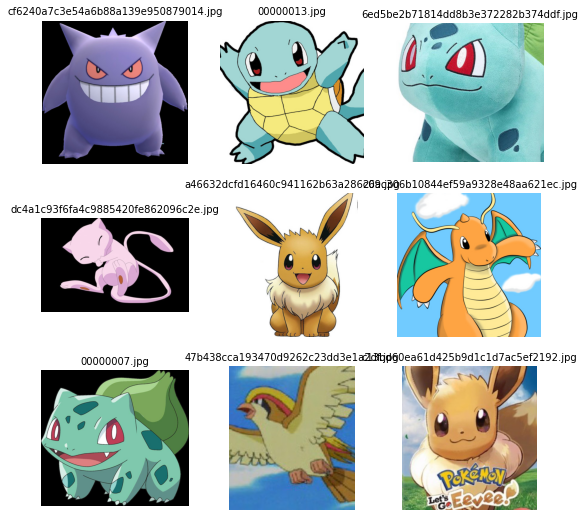

In [7]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
  pic = random.randint(1,len(images)-1)
  plt.subplot(3, 3, i + 1)
  plt.title(str(images[pic]).split('/')[-1], fontsize=10) #get the file name and disply as title
  plt.imshow(PIL.Image.open(images[pic]))
  ax = plt.axis("off")

Como podemos ver las imagenes han sido cargadas correctamente en el codigo.

##DATA AUGMENTATION Y PREPROCESAMIENTO

El data augmentation es el proceso por el cual se aumenta el dataset, esto con el fin de generar muchas imagenes de una sola, con esto aumentamos el tamaño del dataset y obtenemos mas datos para entrenar los diferentes modelos.

En esta etapa se realiza la normalizacion de las imagenes, se les define un tamaño que servira de entrada a la red neuronal.

In [8]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 32  
NUM_EPOCHS = 20
CLASSES = ['Pikachu','Lapras','Articuno','Charizard','Pidgeot','Squirtle',
           'Lickitung','Dragonite','Onix','Butterfree','Gengar','MrMime','Eevee','Mew','Bulbasaur'] 
NUM_CLASSES = 15 

A continuacion se realiza la generacion de imagenes, cabe resaltar que metodos como transfer learning requieren aparte de las carpetas de entrenamiento y prueba una de validacion, por lo que se usa el comando validation_split para dividir las imagenes de entrenamiento en dos conjuntos, el mas grande para entreanmiento y el mas pequeño para validacion, mientras la carperta de prueba no se separa.

In [9]:
test_datagen= ImageDataGenerator(rescale=1./255)
datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False, 
    #preprocessing_function=preprocess_input
    validation_split = 0.2)

train_gen = datagen.flow_from_directory(
        directory=train_dir,  
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        classes = CLASSES,
        seed = 42,
        shuffle = False) 

valid_gen = datagen.flow_from_directory(
        directory=train_dir,  
        target_size=IMAGE_SIZE,  
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        classes = CLASSES,
        seed = 42,
        shuffle = False)

test_gen = datagen.flow_from_directory(
        directory=test_dir,  
        target_size=IMAGE_SIZE,  
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes = CLASSES,
        seed = 42,
        shuffle = False)

Found 503 images belonging to 15 classes.
Found 119 images belonging to 15 classes.
Found 63 images belonging to 15 classes.


A continuacion probamos como actua el data augmentation en una imagen de un pokemon.

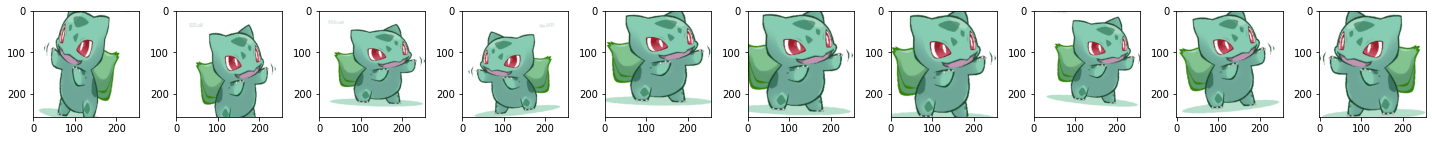

(256, 256, 3)


In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        Image = np.clip(img, 0, 1)
        ax.imshow(Image)
    plt.tight_layout()
    plt.show()
    print(Image.shape)

augmented_images = [train_gen[15][0][1] for i in range(10)]
plotImages(augmented_images)

##RED MLP

Con el dataset listo procedemos a realizar el primer modelo de red neuronal, para ello se entrenara una red neuronal de perceptron multicapa (MLP), esta se caracteriza por ser una secuencia de capas de neuronas conectadas unas a otras secuencialmente.

Para este modelo se utilizaran una serie de capas con activacion relu, donde se tiene una capa de entrada de 256*256*3 que hacen alegoria al tamaño de la imagen y sus 3 canales, a esta se le agregaran capas ocultas que iran reduciendo las neuronas de la capa a la mitad, hasta llegar a la capa de salida con 15 neuronas y de activacion softmax donde cada una representa una clase de pokemon.

In [11]:
import tensorflow as tf
from tensorflow import keras

modelMLP = keras.Sequential([
    keras.layers.Flatten(input_shape=(256,256,3)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),

    keras.layers.Dense(15, activation='softmax')
])

In [12]:

modelMLP.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])


In [13]:
from keras.callbacks import ModelCheckpoint

checkpointer1 = ModelCheckpoint(filepath='model1.weights.best.hdf5', verbose = 1, save_best_only=True)
H1 = modelMLP.fit(train_gen,
         batch_size=64,
         epochs=20,
         validation_data=(test_gen),
         callbacks=[checkpointer1])


Epoch 1/20
16/16 [==============================] - 15s 716ms/step - loss: 0.0695 - accuracy: 0.0954 - val_loss: 0.0653 - val_accuracy: 0.0635

Epoch 00001: val_loss improved from inf to 0.06532, saving model to model1.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 11s 682ms/step - loss: 0.0653 - accuracy: 0.0775 - val_loss: 0.0635 - val_accuracy: 0.0794

Epoch 00002: val_loss improved from 0.06532 to 0.06350, saving model to model1.weights.best.hdf5
Epoch 3/20
16/16 [==============================] - 11s 682ms/step - loss: 0.0636 - accuracy: 0.0994 - val_loss: 0.0627 - val_accuracy: 0.0635

Epoch 00003: val_loss improved from 0.06350 to 0.06274, saving model to model1.weights.best.hdf5
Epoch 4/20
16/16 [==============================] - 11s 694ms/step - loss: 0.0634 - accuracy: 0.1332 - val_loss: 0.0624 - val_accuracy: 0.0635

Epoch 00004: val_loss improved from 0.06274 to 0.06243, saving model to model1.weights.best.hdf5
Epoch 5/20
16/16 [======================

Una vez entrenada la red graficamos su perdida y accuracy en funcion de las epocas con el fin de evaluar el comportamiento.

In [14]:
# create a new plot with default tools, using figure
p1 = figure(plot_width=500, plot_height=300)
p1.line(range(NUM_EPOCHS),H1.history['accuracy'], line_width=2,line_color='red',legend_label="Train Accuracy")
p1.line(range(NUM_EPOCHS),H1.history['val_accuracy'], line_width=2, legend_label="Test Accuracy",line_dash=[6, 6])
p1.circle(range(NUM_EPOCHS),H1.history['accuracy'], fill_color="white", size=4)
p1.circle(range(NUM_EPOCHS),H1.history['val_accuracy'], fill_color="white", size=4)
p1.xaxis.axis_label = "N° of Epochs"
p1.yaxis.formatter = NumeralTickFormatter(format="0.0%")
p1.yaxis.axis_label = "Accuracy"
p1.legend.location = "bottom_right"
p2 = figure(plot_width=500, plot_height=300)
p2.line(range(NUM_EPOCHS),H1.history['loss'], line_width=2,line_color='red',legend_label="Train Accuracy")
p2.line(range(NUM_EPOCHS),H1.history['val_loss'], line_width=2, legend_label="Test Accuracy", line_dash=[6, 6])
p2.circle(range(NUM_EPOCHS),H1.history['loss'], fill_color="white", size=4)
p2.circle(range(NUM_EPOCHS),H1.history['val_loss'], fill_color="white", size=4)
p2.xaxis.axis_label = "N° of Epochs"
p2.yaxis.axis_label = "Loss"
show(row(p2,p1))

De las graficas podemos inferir que este modelo no presenta muy buenos resultados ya que el pico mas alto de accuracy es de 10% pero vuelve y cae, sin embargo se pueden aumentar las epocas de entrenamiento hasta obtener mejores resultados, sin embargo requiere mas tiempo de entrenamiento.

A continuacion se presenta los resultados de clasificacion de este modelo.

In [15]:
modelMLP1 = load_model('model1.weights.best.hdf5')
test_eval = modelMLP1.evaluate(test_gen)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


2/2 [==============================] - 11s 496ms/step - loss: 0.0622 - accuracy: 0.0635
Test loss: 0.06222342699766159
Test accuracy: 0.0634920671582222


In [16]:
predicted_classesMLP = modelMLP1.predict(test_gen)
predicted_classesMLP = np.argmax(predicted_classesMLP,axis=1)
print('salida predicha\n',predicted_classesMLP)

true_labelsFT = test_gen.classes
print('\nsalida real \n',true_labelsFT[:])

salida predicha
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

salida real 
 [ 0  0  0  0  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  5  5
  5  5  5  6  6  6  6  7  7  7  8  8  8  8  8  9  9  9 10 10 10 10 11 11
 11 11 12 12 12 12 12 13 13 13 14 14 14 14 14]


Al comparar los vectores anteriores podemos ver que la salida del modelo es mala y no logra hacer la clasificacón.

---------


##CNN


El segundo modelo a entrenar es una red convolucional, esta red se caracteriza por tener una secuencia definida de capas, donde la imagen pasa por diferentes filtros y diferentes tipos de activacion, la estructura basica de esta red es la capa de entrada, a continuacion un maxPooling y luego una capa de activacion relu, esto se puede repetir hasta lograr las capas que sean necesarias para obtener buenos resultados, cabe resaltar que la capa de salida tambien es softmax y es de tamaño 15 como el numero de clases que se tienen.



In [17]:
import tensorflow as tf
from tensorflow import keras
ModelCNN = keras.Sequential()
ModelCNN.add(keras.layers.Conv2D(128,3,input_shape=(220,220,3),activation='relu'))
ModelCNN.add(keras.layers.MaxPool2D())
ModelCNN.add(keras.layers.Conv2D(128,3,activation='relu'))
ModelCNN.add(keras.layers.MaxPool2D())
ModelCNN.add(keras.layers.Conv2D(128,3,strides=(2,2),activation='relu'))
ModelCNN.add(keras.layers.MaxPool2D())
ModelCNN.add(keras.layers.BatchNormalization())
ModelCNN.add(keras.layers.Conv2D(64,3,strides=(2,2),activation='relu'))
ModelCNN.add(keras.layers.MaxPool2D())
ModelCNN.add(keras.layers.Flatten())
ModelCNN.add(keras.layers.Dropout(0.2))
ModelCNN.add(keras.layers.Dense(1024,activation='relu'))
ModelCNN.add(keras.layers.Dense(512,activation='relu'))
ModelCNN.add(keras.layers.Dense(15,activation='softmax'))

In [18]:
ModelCNN.compile(loss='categorical_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint

checkpointer2 = ModelCheckpoint(filepath='model2.weights.best.hdf5', verbose = 1, save_best_only=True)
H2 = ModelCNN.fit(train_gen,
         batch_size=64,
         epochs=20,
         validation_data=(test_gen),
         callbacks=[checkpointer2])

Epoch 1/20
16/16 [==============================] - 48s 1s/step - loss: 3.2054 - accuracy: 0.0080 - val_loss: 2.7080 - val_accuracy: 0.0952

Epoch 00001: val_loss improved from inf to 2.70796, saving model to model2.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 12s 740ms/step - loss: 2.7259 - accuracy: 0.0755 - val_loss: 2.7082 - val_accuracy: 0.0952

Epoch 00002: val_loss did not improve from 2.70796
Epoch 3/20
16/16 [==============================] - 12s 737ms/step - loss: 2.7096 - accuracy: 0.0795 - val_loss: 2.7083 - val_accuracy: 0.0794

Epoch 00003: val_loss did not improve from 2.70796
Epoch 4/20
16/16 [==============================] - 12s 727ms/step - loss: 2.7206 - accuracy: 0.0636 - val_loss: 2.7078 - val_accuracy: 0.0635

Epoch 00004: val_loss improved from 2.70796 to 2.70777, saving model to model2.weights.best.hdf5
Epoch 5/20
16/16 [==============================] - 12s 692ms/step - loss: 2.6654 - accuracy: 0.0835 - val_loss: 2.6752 - val_accuracy:

In [20]:
# create a new plot with default tools, using figure
p1 = figure(plot_width=500, plot_height=300)
p1.line(range(NUM_EPOCHS),H2.history['accuracy'], line_width=2,line_color='red',legend_label="Train Accuracy")
p1.line(range(NUM_EPOCHS),H2.history['val_accuracy'], line_width=2, legend_label="Test Accuracy",line_dash=[6, 6])
p1.circle(range(NUM_EPOCHS),H2.history['accuracy'], fill_color="white", size=4)
p1.circle(range(NUM_EPOCHS),H2.history['val_accuracy'], fill_color="white", size=4)
p1.xaxis.axis_label = "N° of Epochs"
p1.yaxis.formatter = NumeralTickFormatter(format="0.0%")
p1.yaxis.axis_label = "Accuracy"
p1.legend.location = "bottom_right"
p2 = figure(plot_width=500, plot_height=300)
p2.line(range(NUM_EPOCHS),H2.history['loss'], line_width=2,line_color='red',legend_label="Train Accuracy")
p2.line(range(NUM_EPOCHS),H2.history['val_loss'], line_width=2, legend_label="Test Accuracy", line_dash=[6, 6])
p2.circle(range(NUM_EPOCHS),H2.history['loss'], fill_color="white", size=4)
p2.circle(range(NUM_EPOCHS),H2.history['val_loss'], fill_color="white", size=4)
p2.xaxis.axis_label = "N° of Epochs"
p2.yaxis.axis_label = "Loss"
show(row(p2,p1))

Como podemos ver en este modelo se presentan mejores resultados comparado con MLP donde se tiene un accuracy de 43% con el mismo número de epocas

In [21]:
modelCNN1 = load_model('model2.weights.best.hdf5')
test_eval = modelCNN1.evaluate(test_gen)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


2/2 [==============================] - 5s 519ms/step - loss: 2.0863 - accuracy: 0.2857
Test loss: 2.086334466934204
Test accuracy: 0.2857142984867096


In [22]:
predicted_classesCNN = modelCNN1.predict(test_gen)
predicted_classesCNN= np.argmax(predicted_classesCNN,axis=1)
print('salida predicha\n',predicted_classesCNN)

true_labelsFT = test_gen.classes
print('\nsalida real \n',true_labelsFT[:])

salida predicha
 [ 0  0  0  0 13  1  2 13  2  2 13 13 13  0  7  0  7  0  0  4  0  0 13 13
  5  5  5 13 13 13 13  0  0  0 13 13 13 13 13 13 11  2 13 11 13 13 13 13
 13 13  0  0 11  0 12 13 13 13 14 14  2 14 13]

salida real 
 [ 0  0  0  0  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  5  5
  5  5  5  6  6  6  6  7  7  7  8  8  8  8  8  9  9  9 10 10 10 10 11 11
 11 11 12 12 12 12 12 13 13 13 14 14 14 14 14]


En este modelo aun se tiene un alto margen de error por lo que la clasificacion no es apropiada, sin embargo comparada con MLP tiene algunos aciertos, aun asi no es una red suficientemente confiable para este dataset.

##TRANSFER LEARNING

El ultimo modelo de este proyecto se basa en transfer learning, este consiste en ingresar nuestros datos a una red previamente entrenada, la ventaja de esto es que se puede ahorrar tiempo de procesamiento y tener buenos resultados disminuyendo el error debido a que estas redes se han entrenado para casos similares al deseado en este caso clasificacion de imagenes.

Para este modelo se utiliza la funcion VGG16 de keras la cual trae los pesos de una red entrenada para clasificacion de imagenes, con este modelo solo queda ingresarle nuestro dataset y entrenar el modelo.



In [23]:
tlm = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in tlm.layers:
    layer.trainable = False

x = Flatten()(tlm.output)
prediction = Dense(NUM_CLASSES, activation='softmax')(x) 

model = Model(inputs=tlm.input, outputs=prediction)
model.summary()  

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [24]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='nadam',
  metrics=['accuracy']
)

In [25]:
checkpointer3 = ModelCheckpoint(filepath='model3.weights.best.hdf5', verbose = 1, save_best_only=True)
H3 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen),
    callbacks=[checkpointer3])

Epoch 1/20
16/16 [==============================] - 30s 1s/step - loss: 7.0565 - accuracy: 0.0775 - val_loss: 7.2399 - val_accuracy: 0.0840

Epoch 00001: val_loss improved from inf to 7.23992, saving model to model3.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 13s 825ms/step - loss: 6.2710 - accuracy: 0.0264 - val_loss: 3.9270 - val_accuracy: 0.1597

Epoch 00002: val_loss improved from 7.23992 to 3.92703, saving model to model3.weights.best.hdf5
Epoch 3/20
16/16 [==============================] - 13s 837ms/step - loss: 3.4011 - accuracy: 0.1233 - val_loss: 1.1839 - val_accuracy: 0.6471

Epoch 00003: val_loss improved from 3.92703 to 1.18386, saving model to model3.weights.best.hdf5
Epoch 4/20
16/16 [==============================] - 13s 825ms/step - loss: 0.8642 - accuracy: 0.7270 - val_loss: 1.4952 - val_accuracy: 0.5798

Epoch 00004: val_loss did not improve from 1.18386
Epoch 5/20
16/16 [==============================] - 13s 821ms/step - loss: 0.8171 - accur

In [26]:
# create a new plot with default tools, using figure
p1 = figure(plot_width=500, plot_height=300)
p1.line(range(NUM_EPOCHS),H3.history['accuracy'], line_width=2,line_color='red',legend_label="Train Accuracy")
p1.line(range(NUM_EPOCHS),H3.history['val_accuracy'], line_width=2, legend_label="Test Accuracy",line_dash=[6, 6])
p1.circle(range(NUM_EPOCHS),H3.history['accuracy'], fill_color="white", size=4)
p1.circle(range(NUM_EPOCHS),H3.history['val_accuracy'], fill_color="white", size=4)
p1.xaxis.axis_label = "N° of Epochs"
p1.yaxis.formatter = NumeralTickFormatter(format="0.0%")
p1.yaxis.axis_label = "Accuracy"
p1.legend.location = "bottom_right"
p2 = figure(plot_width=500, plot_height=300)
p2.line(range(NUM_EPOCHS),H3.history['loss'], line_width=2,line_color='red',legend_label="Train Accuracy")
p2.line(range(NUM_EPOCHS),H3.history['val_loss'], line_width=2, legend_label="Test Accuracy", line_dash=[6, 6])
p2.circle(range(NUM_EPOCHS),H3.history['loss'], fill_color="white", size=4)
p2.circle(range(NUM_EPOCHS),H3.history['val_loss'], fill_color="white", size=4)
p2.xaxis.axis_label = "N° of Epochs"
p2.yaxis.axis_label = "Loss"
show(row(p2,p1))

Como podemos observar transfer learning brinda una respuesta confiable ya que llega a un accuracy aceptable a las 15 epocas, el accuracy maximo obtenido es de 100%

In [27]:
modelFE = load_model('model3.weights.best.hdf5')
test_eval = modelFE.evaluate(test_gen)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])



2/2 [==============================] - 9s 8s/step - loss: 0.1869 - accuracy: 0.9524
Test loss: 0.18691317737102509
Test accuracy: 0.9523809552192688


In [28]:
predicted_classesFT = modelFE.predict(test_gen)
predicted_classesFT = np.argmax(predicted_classesFT,axis=1)
print(predicted_classesFT)

true_labelsFT = test_gen.classes
print(true_labelsFT[:])

[ 0  0  0  0  1  1  1  1 13  2  2  2  2  3  3  7  3  3  4  4  4  4  5  5
  5  5  5  6  6  6  6  7  7  7  8  8  8  8  8  9  9  4 10 10 10 10 11 11
 11 11 12 12 12 12 12 13 13 13 14 14 13 14  1]
[ 0  0  0  0  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  5  5
  5  5  5  6  6  6  6  7  7  7  8  8  8  8  8  9  9  9 10 10 10 10 11 11
 11 11 12 12 12 12 12 13 13 13 14 14 14 14 14]


Como podemos ver en lo anterior la clasificacion se realiza mucho mejor, aunque se tienen algunos fallos, esto se pued solucionar aumentado las epocas de entrenamiento.

##Comparacion

Por ultimo realizaremos la comparacion de los 3 modelos a partir de 3 herramientas diferentes, la primera a travez de el clasification report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


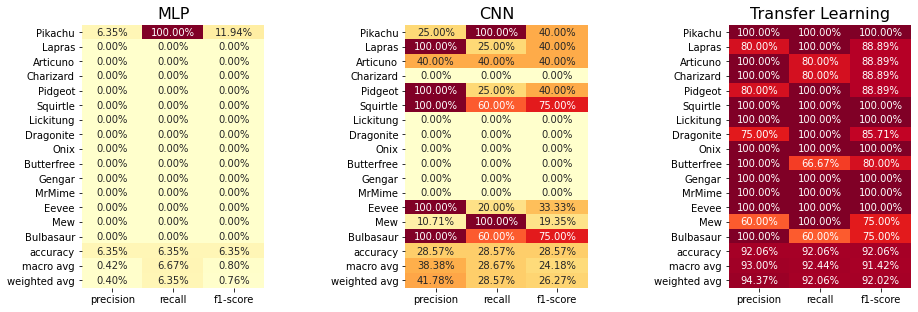

In [29]:
Clases = train_gen.class_indices
fig, ax = plt.subplots(figsize=(15,7),ncols=3,nrows=1)
fig.tight_layout(pad=11.0)
clf_report1 = classification_report(true_labelsFT, predicted_classesMLP, digits = 4, target_names=[*Clases], output_dict=True)
clf_report2 = classification_report(true_labelsFT, predicted_classesCNN, digits = 4, target_names=[*Clases], output_dict=True)
clf_report3 = classification_report(true_labelsFT, predicted_classesFT, digits = 4, target_names=[*Clases], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report1).iloc[:-1, :].T, annot=True,ax=ax[0], cbar=False, cmap='YlOrRd',fmt=".2%", cbar_kws={"ticks":[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]},
            vmin = 0, vmax=1)
ax[0].set_title('MLP',fontsize = 16)
sns.heatmap(pd.DataFrame(clf_report2).iloc[:-1, :].T, annot=True,ax=ax[1], cbar=False, cmap='YlOrRd', fmt=".2%", cbar_kws={"ticks":[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]},
            vmin = 0, vmax=1)
ax[1].set_title('CNN',fontsize = 16)
sns.heatmap(pd.DataFrame(clf_report3).iloc[:-1, :].T, annot=True,ax=ax[2], cbar=False, cmap='YlOrRd', fmt=".2%", cbar_kws={"ticks":[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]},
            vmin = 0, vmax=1)
ax[2].set_title('Transfer Learning',fontsize = 16)
plt.show()

En el grafico anterior podemos ver como MLP solo logra buena precision en la clase pikachu, mientras CNN mejora la presicion en varias clases pero no es aun eficiente, por ultimo transfer learning tiene una alta tasa de precision en la mayoria de clases.

------------


**Matriz de confusion**



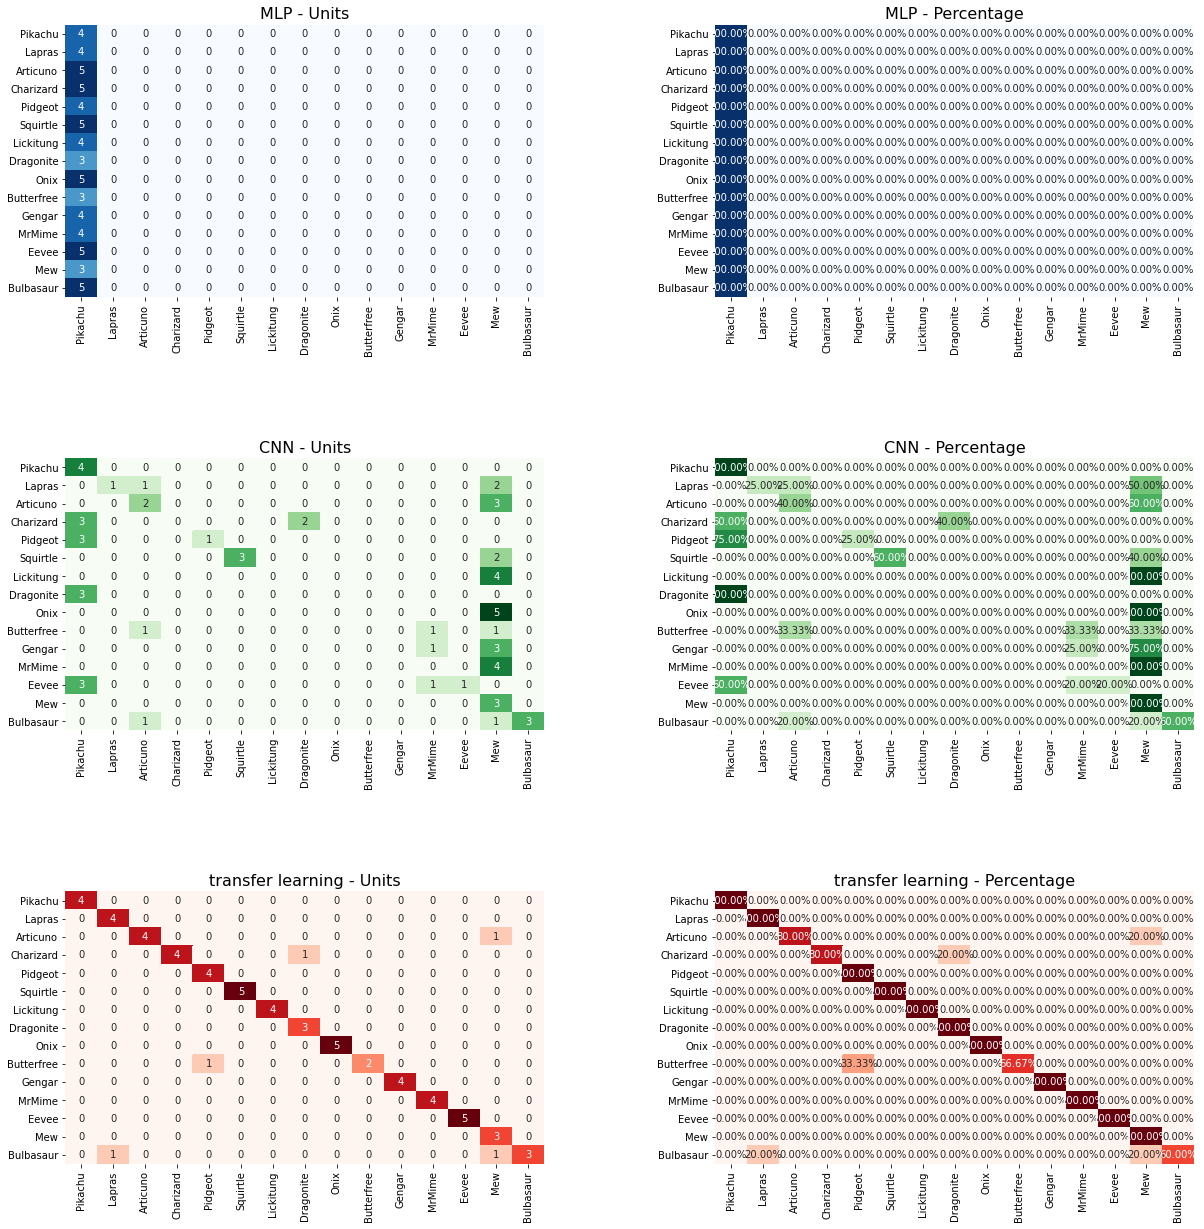

In [30]:
fig, ax = plt.subplots(figsize=(20,20),ncols=2,nrows=3)
fig.tight_layout(pad=14.0)
ax[0][0].set_title('MLP - Units',fontsize = 16)
ax[0][1].set_title('MLP - Percentage',fontsize = 16)
ax[1][0].set_title('CNN - Units',fontsize = 16)
ax[1][1].set_title('CNN - Percentage',fontsize = 16)
ax[2][0].set_title('transfer learning - Units',fontsize = 16)
ax[2][1].set_title('transfer learning - Percentage',fontsize = 16)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesMLP), fmt="d", annot=True, ax=ax[0][0], 
            cmap=plt.cm.Blues, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesMLP, normalize='true'), fmt=".2%", annot=True, ax=ax[0][1],
            cmap=plt.cm.Blues, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesCNN), fmt="d", annot=True, ax=ax[1][0], 
            cmap=plt.cm.Greens, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesCNN, normalize='true'), fmt=".2%", annot=True, ax=ax[1][1],
            cmap=plt.cm.Greens, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesFT), fmt="d", annot=True, ax=ax[2][0], 
            cmap=plt.cm.Reds, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
sns.heatmap(confusion_matrix(true_labelsFT, predicted_classesFT, normalize='true'), fmt=".2%", annot=True, ax=ax[2][1],
            cmap=plt.cm.Reds, xticklabels=[*Clases], yticklabels=[*Clases], cbar=False)
plt.show()

En la matriz de confusion podemos ver el nivel de aciertos de las redes, y otra vez comprobamos que la mejor clasificacion de clases se da con el modelo de transfer learning

Curva ROC


In [31]:
def plot_roc_curve(true_labels,predicted_classes,NUM_CLASSES, mode,**kwargs):
  plt.rcParams["figure.figsize"] = (6,4)
  fpr = dict()
  tpr = dict()
  lw=2
  roc_auc = dict()
  lb = LabelBinarizer()
  lb.fit(true_labels)
  true_labelsB = lb.transform(true_labels)
  predicted_classesB = lb.transform(predicted_classes)

  for i in range(NUM_CLASSES):
      fpr[i], tpr[i], _ = roc_curve(true_labelsB[i], predicted_classesB[i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(true_labelsB[i].ravel(), predicted_classesB[i].ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(NUM_CLASSES):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= NUM_CLASSES

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue','yellow','red','green','blue','orange','purple','brown'])
  for i, color in zip(range(NUM_CLASSES), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(CLASSES[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  title = 'Multi-class ROC Curve: '+mode
  plt.title(title)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

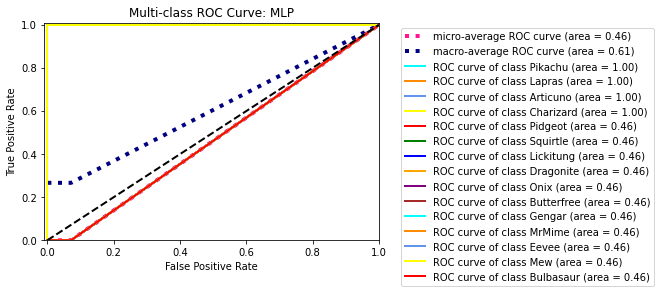

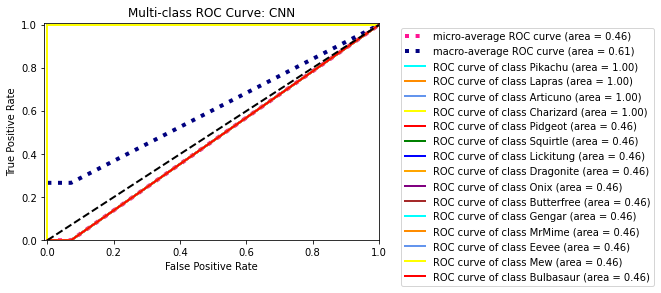

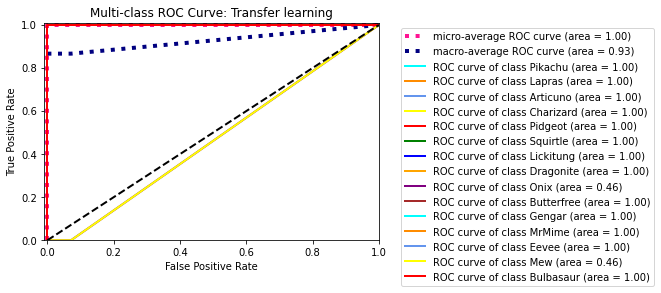

In [48]:
plot_roc_curve(true_labelsFT,predicted_classesMLP,NUM_CLASSES,'MLP')
plot_roc_curve(true_labelsFT,predicted_classesCNN,NUM_CLASSES, 'CNN')
plot_roc_curve(true_labelsFT,predicted_classesFT,NUM_CLASSES, 'Transfer learning')

Por ultimo la curva roc nos muestra el ratio de verdaderos positivos comparados con los falsos positivos, con esta herramienta podemos ver que el mejor comportamiento esta en transfer learning ya que muchas de sus clases tienen un ratio de 1 y solo las clases mew y onix no se estan clasificando adecuadamente.

--------


**CONCLUSIONES**

* El proyecto arrojo que la mejor herramienta de clasificacion es el transfer learning sin embargo hay que tener en cuenta que esta depende de una red entrenada previamente.
* La red CNN ofrece mejores resultados que MLP ya que tuvo un accuracy de 39%, sin embargo es un modelo que entrena mas lento que MLP
* MLP es una red basica que puede ofrecer resultados si se establecen las capas adecuadas, ya que al aumentar las capas se puede producir sobreentrenamiento y si se deja con pocas no se logra la clasificacion.


REFERENCIAS

[1]Sin nombre. "vgg16 y vgg19" disponible en https://keras.io/api/applications/vgg/

[2]Sin nombre."Transferir el aprendizaje en Keras con modelos de visión por computadora", en linea. Disponible en https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/